In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import joblib

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
df = pd.read_csv("../Data/Match Winner.csv")

print("Shape:", df.shape)
df.head()


Shape: (6840, 40)


,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,...,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts
0,0,19/08/00,Charlton,Man City,4,0,H,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,1,19/08/00,Chelsea,West Ham,4,2,H,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,2,19/08/00,Coventry,Middlesbrough,1,3,NH,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,3,19/08/00,Derby,Southampton,2,2,NH,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
4,4,19/08/00,Leeds,Everton,2,0,H,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0


In [3]:
print("=== BASIC INFO ===")
print(df.info())

print("\n=== NULL VALUES ===")
print(df.isnull().sum().sum(), "total null values")

print("\n=== DUPLICATES ===")
print("Duplicate rows:", df.duplicated().sum())

# Drop columns we don't want as features
drop_cols = ['Unnamed: 0', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']
drop_cols = [c for c in drop_cols if c in df.columns]

df = df.drop(columns=drop_cols)

print("\nAfter dropping columns, shape:", df.shape)
df.head()


=== BASIC INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6840 entries, 0 to 6839
Data columns (total 40 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     6840 non-null   int64  
 1   Date           6840 non-null   object 
 2   HomeTeam       6840 non-null   object 
 3   AwayTeam       6840 non-null   object 
 4   FTHG           6840 non-null   int64  
 5   FTAG           6840 non-null   int64  
 6   FTR            6840 non-null   object 
 7   HTGS           6840 non-null   int64  
 8   ATGS           6840 non-null   int64  
 9   HTGC           6840 non-null   int64  
 10  ATGC           6840 non-null   int64  
 11  HTP            6840 non-null   float64
 12  ATP            6840 non-null   float64
 13  HM1            6840 non-null   object 
 14  HM2            6840 non-null   object 
 15  HM3            6840 non-null   object 
 16  HM4            6840 non-null   object 
 17  HM5            6840 non-null   ob

,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,HM2,HM3,...,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts
0,H,0,0,0,0,0.0,0.0,M,M,M,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,H,0,0,0,0,0.0,0.0,M,M,M,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,NH,0,0,0,0,0.0,0.0,M,M,M,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,NH,0,0,0,0,0.0,0.0,M,M,M,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
4,H,0,0,0,0,0.0,0.0,M,M,M,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0


In [4]:
data = df.copy()

# 1) Gap in goal difference between home and away
data['Goal_Difference_Gap'] = data['HTGD'] - data['ATGD']

# 2) Gap in points
data['Points_Gap'] = data['HTP'] - data['ATP']

# 3) Away goal difference
data['Away_Goal_Difference'] = data['ATGD']

# 4) Home goal difference
data['Home_Goal_Difference'] = data['HTGD']

# 5) Form gap (home form pts - away form pts)
data['Form_Gap'] = data['HTFormPts'] - data['ATFormPts']

# 6) Home goals scored
data['Home_Goals_Scored'] = data['HTGS']

# 7) Away win streak (5-match)
data['Away_Win_Streak'] = data['ATWinStreak5']

# 8) Home goals conceded
data['Home_Goals_Conceded'] = data['HTGC']

# 9) Away goals scored
data['Away_Goals_Scored'] = data['ATGS']

# 10) Home win streak (5-match)
data['Home_Win_Streak'] = data['HTWinStreak5']

feature_cols = [
    'Goal_Difference_Gap',
    'Points_Gap',
    'Away_Goal_Difference',
    'Home_Goal_Difference',
    'Form_Gap',
    'Home_Goals_Scored',
    'Away_Win_Streak',
    'Home_Goals_Conceded',
    'Away_Goals_Scored',
    'Home_Win_Streak'
]

data[feature_cols].head()


,Goal_Difference_Gap,Points_Gap,Away_Goal_Difference,Home_Goal_Difference,Form_Gap,Home_Goals_Scored,Away_Win_Streak,Home_Goals_Conceded,Away_Goals_Scored,Home_Win_Streak
0,0.0,0.0,0.0,0.0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0,0,0,0,0,0


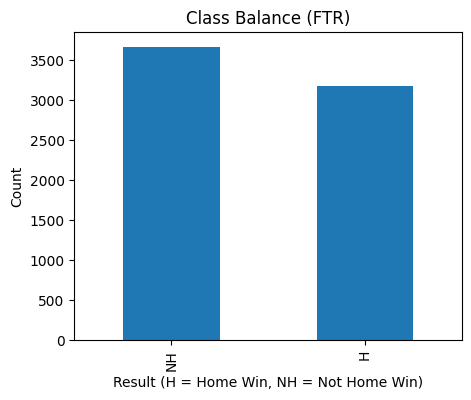

In [5]:
plt.figure(figsize=(5,4))
data['FTR'].value_counts().plot(kind='bar')
plt.title("Class Balance (FTR)")
plt.xlabel("Result (H = Home Win, NH = Not Home Win)")
plt.ylabel("Count")
plt.show()


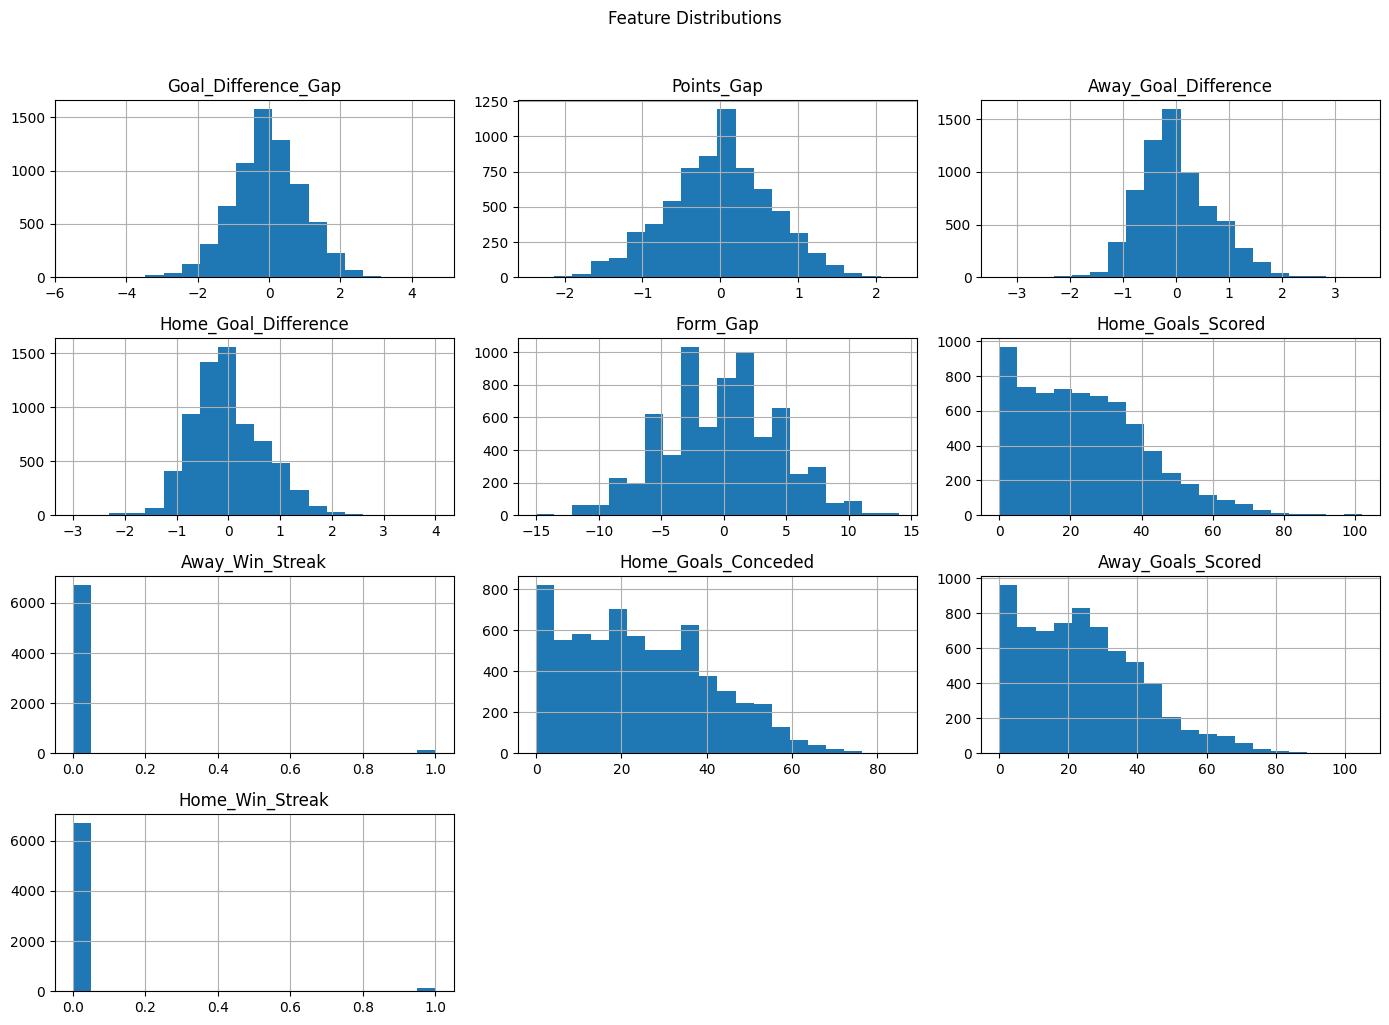

In [6]:
data[feature_cols].hist(figsize=(14,10), bins=20)
plt.suptitle("Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()


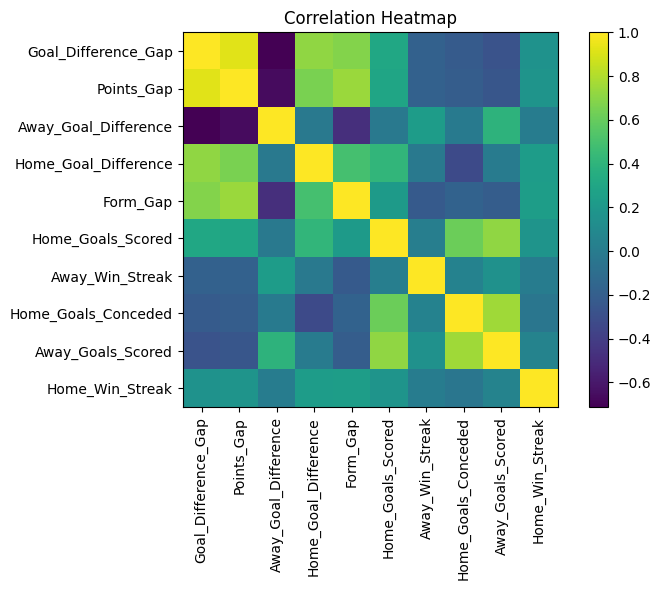

In [7]:
corr = data[feature_cols].corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest')
plt.title("Correlation Heatmap")
plt.colorbar()
tick_marks = range(len(feature_cols))
plt.xticks(tick_marks, feature_cols, rotation=90)
plt.yticks(tick_marks, feature_cols)
plt.tight_layout()
plt.show()


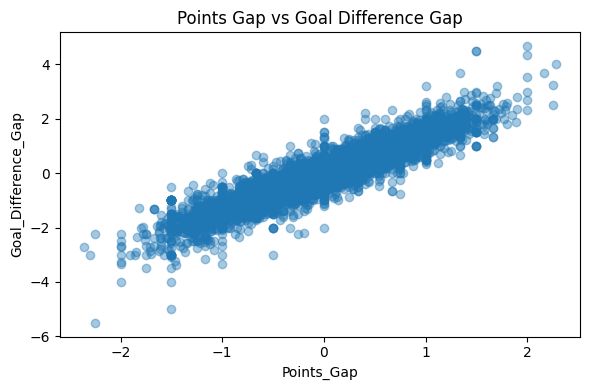

In [8]:
plt.figure(figsize=(6,4))
plt.scatter(data['Points_Gap'], data['Goal_Difference_Gap'], alpha=0.4)
plt.xlabel("Points_Gap")
plt.ylabel("Goal_Difference_Gap")
plt.title("Points Gap vs Goal Difference Gap")
plt.tight_layout()
plt.show()


In [9]:
# Features
X = data[feature_cols].copy()

# Target: map H -> 1, NH -> 0
y = data['FTR'].map({'H': 1, 'NH': 0})

print("Class balance:")
print(y.value_counts(normalize=True))

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape


Class balance:
FTR
0    0.535673
1    0.464327
Name: proportion, dtype: float64


((5472, 10), (1368, 10))

In [10]:
def evaluate_cv(model, X, y, cv_splits=5):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
    return scores


In [11]:
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

print("=== Logistic Regression (Cross-Validation) ===")
lr_cv_scores = evaluate_cv(logreg_pipeline, X, y, cv_splits=5)

# Fit on train, evaluate on held-out test
logreg_pipeline.fit(X_train, y_train)
y_pred_lr = logreg_pipeline.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
print("\n=== Logistic Regression – Test Set ===")
print("Accuracy:", acc_lr)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))


=== Logistic Regression (Cross-Validation) ===
CV Accuracy: 0.6329 ± 0.0095

=== Logistic Regression – Test Set ===
Accuracy: 0.6293859649122807

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.73      0.68       733
           1       0.62      0.51      0.56       635

    accuracy                           0.63      1368
   macro avg       0.63      0.62      0.62      1368
weighted avg       0.63      0.63      0.62      1368

Confusion Matrix:
[[535 198]
 [309 326]]


In [12]:
rf_base = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("=== Random Forest (Base) – Cross-Validation ===")
rf_cv_scores_base = evaluate_cv(rf_base, X, y, cv_splits=5)

rf_base.fit(X_train, y_train)
y_pred_rf_base = rf_base.predict(X_test)

acc_rf_base = accuracy_score(y_test, y_pred_rf_base)
print("\n=== Random Forest (Base) – Test Set ===")
print("Accuracy:", acc_rf_base)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_base))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_base))


=== Random Forest (Base) – Cross-Validation ===
CV Accuracy: 0.6083 ± 0.0178

=== Random Forest (Base) – Test Set ===
Accuracy: 0.6308479532163743

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.72      0.68       733
           1       0.62      0.53      0.57       635

    accuracy                           0.63      1368
   macro avg       0.63      0.62      0.62      1368
weighted avg       0.63      0.63      0.63      1368

Confusion Matrix:
[[526 207]
 [298 337]]


In [13]:
rf = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1
)

param_distributions = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=25,              # you can increase to 50+ if you want
    scoring='accuracy',
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("=== Hyperparameter Tuning: Random Forest ===")
rf_random_search.fit(X_train, y_train)

print("\nBest CV Accuracy:", rf_random_search.best_score_)
print("Best Params:", rf_random_search.best_params_)


=== Hyperparameter Tuning: Random Forest ===
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best CV Accuracy: 0.6370607631497667
Best Params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5}


In [14]:
best_rf = rf_random_search.best_estimator_

best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)

print("=== Tuned Random Forest – Test Set ===")
print("Accuracy:", acc_rf)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nComparison:")
print(f"LogReg Test Accuracy:        {acc_lr:.4f}")
print(f"RF Base Test Accuracy:       {acc_rf_base:.4f}")
print(f"Tuned RF Test Accuracy:      {acc_rf:.4f}")


=== Tuned Random Forest – Test Set ===
Accuracy: 0.6337719298245614

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.78      0.69       733
           1       0.65      0.47      0.54       635

    accuracy                           0.63      1368
   macro avg       0.64      0.62      0.62      1368
weighted avg       0.64      0.63      0.62      1368

Confusion Matrix:
[[570 163]
 [338 297]]

Comparison:
LogReg Test Accuracy:        0.6294
RF Base Test Accuracy:       0.6308
Tuned RF Test Accuracy:      0.6338


                Feature  Importance
0   Goal_Difference_Gap    0.310140
1            Points_Gap    0.218197
3  Home_Goal_Difference    0.125467
2  Away_Goal_Difference    0.120709
4              Form_Gap    0.105013
5     Home_Goals_Scored    0.047593
8     Away_Goals_Scored    0.037658
7   Home_Goals_Conceded    0.033442
9       Home_Win_Streak    0.000955
6       Away_Win_Streak    0.000825


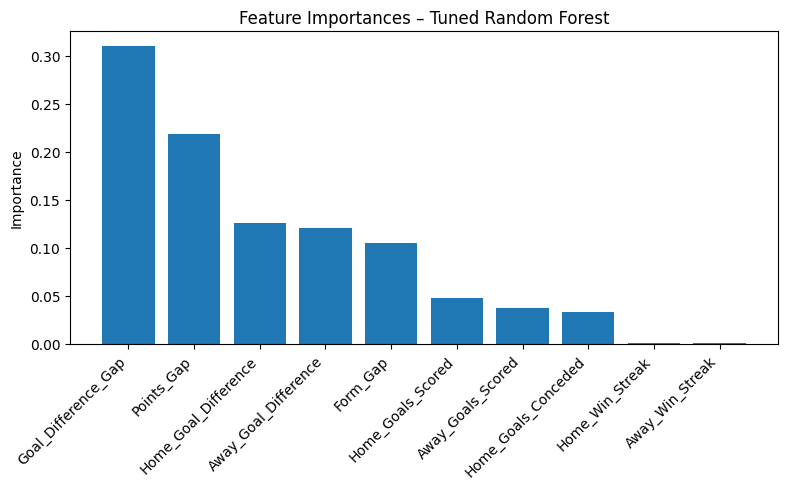

In [15]:
importances = best_rf.feature_importances_
feat_imp = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": importances
}).sort_values("Importance", ascending=False)

print(feat_imp)

plt.figure(figsize=(8,5))
plt.bar(feat_imp["Feature"], feat_imp["Importance"])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Importance")
plt.title("Feature Importances – Tuned Random Forest")
plt.tight_layout()
plt.show()


In [17]:
joblib.dump(best_rf, "best_match_winner_rf.joblib")
joblib.dump(feature_cols, "match_winner_features.joblib")

print("Saved model and feature list.")


Saved model and feature list.
